In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
!pip install pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

     |████████████████████████████████| 527 kB 8.6 MB/s 
     |████████████████████████████████| 829 kB 89.5 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 952 kB 66.8 MB/s 
     |████████████████████████████████| 133 kB 106.8 MB/s 
     |████████████████████████████████| 396 kB 59.2 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 81.3 MB/s 
     |████████████████████████████████| 271 kB 101.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=5585f28672783e1b88a2b9a5fbdca52de3e8b903e2963852b9f98d51820da74c
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successf

In [3]:
class Dataset_torch(Dataset):

    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data['y'])    

    def __getitem__(self, idx):
        
        inputs = [self.data['x1'][idx],self.data['x2'][idx].float()]
        return inputs, self.data['y'][idx]
        

In [5]:
data_18 = torch.load('/content/drive/MyDrive/sar_img/dataset/tensors_2018.pt')
dataset_2018 = Dataset_torch(data_18)
data_loader_2018 = torch.utils.data.DataLoader(dataset=dataset_2018, batch_size=1024,num_workers=4)

# Compute benchmark MSE

In [6]:
class Net_spectral(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        # self.conv4 = nn.Conv2d(256, 512, 3)

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)

        self.fc512_n1 = nn.Linear(256, 256)
        self.fc512_n2 = nn.Linear(256, 256)

    def forward(self, x):
        x = self.maxpooling2d(F.relu(self.conv1(x)))
        x = self.maxpooling2d(F.relu(self.conv2(x)))
        x = self.maxpooling2d(F.relu(self.conv3(x)))
        # x = self.maxpooling2d(F.relu(self.conv4(x)))
        x= self.globalmaxpooling2d(x)
        x = F.relu(self.fc512_n1(torch.squeeze(x)))

        x = F.relu(self.fc512_n2(x))
        x = self.dropout(x)
        return x
class MLP_output(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)
        self.dropout_n3 = nn.Dropout(p=0.5)


        self.fc256 = nn.Linear(256, 256)

        # self.fc1024_512 = nn.Linear(1024, 512)
        self.fc512_256 = nn.Linear(512, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_2 = nn.Linear(128,2)

    def forward(self, x):


        # x = F.relu(self.fc1024_512(x))
        # x = self.dropout_n1(x)
        # x = F.relu(self.fc512_256(x))
        # x = self.dropout_n2(x)
        x = F.relu(self.fc256_128(x))
        x = self.dropout_n3(x)

        output = F.softplus(self.fc128_2(x))

        return output

class Net_cwave(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim = 1)


        self.fc10_64 = nn.Linear(10, 64)
        self.fc64_128 = nn.Linear(64, 128)
        self.fc128_256 = nn.Linear(128, 256)
        self.fc256_512 = nn.Linear(256, 512)
        self.fc512_1024 = nn.Linear(512, 1024)
        self.fc1024_2048 = nn.Linear(1024,2048)

    def forward(self, x):
        x = F.relu(self.fc10_64(x[:,22:]))
        x = F.relu(self.fc64_128(x))
        x = F.relu(self.fc128_256(x))
        x = F.relu(self.fc256_512(x))
        x = F.relu(self.fc512_1024(x))
        x = F.relu(self.fc1024_2048(x))
        x = x.view(-1,8,256)

        x = self.softmax(x)
        x = self.dropout(x)
        return x

# combination of two NN
class Net_comb(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveMaxPool2d(1)

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)

        self.fc256 = nn.Linear(256, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_1 = nn.Linear(128, 1)

        self.net_cwave = Net_cwave()

        self.net_spectral_n1 = Net_spectral()
        self.net_spectral_n2 = Net_spectral()
        self.net_spectral_n3 = Net_spectral()
        self.net_spectral_n4 = Net_spectral()
        self.net_spectral_n5 = Net_spectral()
        self.net_spectral_n6 = Net_spectral()
        self.net_spectral_n7 = Net_spectral()
        self.net_spectral_n8 = Net_spectral()

        self.mlp_out = MLP_output()
        # self.mlp_out_2 = MLP_output()

    def forward(self, x1,x2):

        cnn_output_n1 = self.net_spectral_n1(x1)
        cnn_output_n2 = self.net_spectral_n2(x1)
        cnn_output_n3 = self.net_spectral_n3(x1)
        cnn_output_n4 = self.net_spectral_n4(x1)
        cnn_output_n5 = self.net_spectral_n5(x1)
        cnn_output_n6 = self.net_spectral_n6(x1)
        cnn_output_n7 = self.net_spectral_n7(x1)
        cnn_output_n8 = self.net_spectral_n8(x1)

        cnn_output_matrix = torch.cat([cnn_output_n1,cnn_output_n2,cnn_output_n3,cnn_output_n4,cnn_output_n5,cnn_output_n6,cnn_output_n7,cnn_output_n8],dim=1)
        cnn_output_matrix = cnn_output_matrix.view(-1,8,256)
        # print(self.net_cwave(x2).size())
        # print(cnn_output_matrix.size())
        x = cnn_output_matrix*self.net_cwave(x2)

        x = torch.sum(x,1)

        output = self.mlp_out(x)

        return output
    def training_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2.float())


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.squeeze(y_true).float(),y_pre[:,1])
        # loss = F.mse_loss(torch.squeeze(y_pre), torch.squeeze(y_true).float())

        # Logging to TensorBoard by default
        self.log('train_loss', loss )

        return loss

    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)

        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)

        return loss

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 1)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }

model = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/test_k8.ckpt')
trainer = pl.Trainer(gpus=1)
    
test_mse = trainer.test(model=model,test_dataloaders = data_loader_2018)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.10039879051561472}
--------------------------------------------------------------------------------


# Evaluate the MSE when some high level features have been shuffled

In [7]:
accuracy_list_total = []
name_features_list = ['spatial and time different','location','time of day','incidence angle', 'incidence mode','satellite source']
n_features_list = [2,4,1,1,1,1]
start = 22

for i in n_features_list:

  end = start + i

  # combination of two NN
  class Net_comb(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveMaxPool2d(1)

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)

        self.fc256 = nn.Linear(256, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_1 = nn.Linear(128, 1)

        self.net_cwave = Net_cwave()

        self.net_spectral_n1 = Net_spectral()
        self.net_spectral_n2 = Net_spectral()
        self.net_spectral_n3 = Net_spectral()
        self.net_spectral_n4 = Net_spectral()
        self.net_spectral_n5 = Net_spectral()
        self.net_spectral_n6 = Net_spectral()
        self.net_spectral_n7 = Net_spectral()
        self.net_spectral_n8 = Net_spectral()

        self.mlp_out = MLP_output()
        # self.mlp_out_2 = MLP_output()

    def forward(self, x1,x2):

        cnn_output_n1 = self.net_spectral_n1(x1)
        cnn_output_n2 = self.net_spectral_n2(x1)
        cnn_output_n3 = self.net_spectral_n3(x1)
        cnn_output_n4 = self.net_spectral_n4(x1)
        cnn_output_n5 = self.net_spectral_n5(x1)
        cnn_output_n6 = self.net_spectral_n6(x1)
        cnn_output_n7 = self.net_spectral_n7(x1)
        cnn_output_n8 = self.net_spectral_n8(x1)

        cnn_output_matrix = torch.cat([cnn_output_n1,cnn_output_n2,cnn_output_n3,cnn_output_n4,cnn_output_n5,cnn_output_n6,cnn_output_n7,cnn_output_n8],dim=1)
        cnn_output_matrix = cnn_output_matrix.view(-1,8,256)
        # print(self.net_cwave(x2).size())
        # print(cnn_output_matrix.size())
        x = cnn_output_matrix*self.net_cwave(x2)

        x = torch.sum(x,1)

        output = self.mlp_out(x)

        return output
    def training_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2.float())


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.squeeze(y_true).float(),y_pre[:,1])
        # loss = F.mse_loss(torch.squeeze(y_pre), torch.squeeze(y_true).float())

        # Logging to TensorBoard by default
        self.log('train_loss', loss )

        return loss

    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)

        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        # shuffle high level features (important)
        x2[:,start:end] = x2[torch.randperm(x2.size()[0])][:,start:end]

        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)

        return loss

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 1)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }


  print(str(start)+'-'+str(end))
  

  model = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/test_k8.ckpt')
  trainer = pl.Trainer(gpus=1)
      
  accuracy_list_total.append(trainer.test(model=model,test_dataloaders = data_loader_2018))

  start = start + i

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


22-24


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.10125509630063931}
--------------------------------------------------------------------------------
24-28


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16618200081527085}
--------------------------------------------------------------------------------
28-29


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1006298831170437}
--------------------------------------------------------------------------------
29-30


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.10046701041757806}
--------------------------------------------------------------------------------
30-31


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.14078922033042707}
--------------------------------------------------------------------------------
31-32


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.10040228495821384}
--------------------------------------------------------------------------------


# MSE of model when the high level features have been shuffled

In [9]:
accuracy_list_total_value = np.array( [ list(i[0].values())[0] for i in accuracy_list_total ])
accuracy_list_total_value

array([0.1012551 , 0.166182  , 0.10062988, 0.10046701, 0.14078922,
       0.10040228])

Text(0.5, 0, 'MSE change - %')

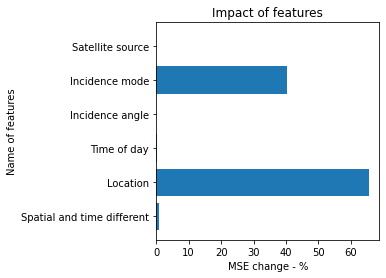

In [16]:
import matplotlib.pyplot as plt

name_features_list = ['Spatial and time different','Location','Time of day','Incidence angle', 'Incidence mode','Satellite source']

plt.figure(figsize=(4, 4))
plt.barh(name_features_list, 100*((accuracy_list_total_value/test_mse[0]['test_loss'])-1))

plt.title('Impact of features')
plt.ylabel('Name of features')
plt.xlabel('MSE change - %')